![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Marty McFly |
<b>Student-nr</b>: C25 |
<b>Date</b>: June 12, 2015
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of algorithmic components). The code examples in this assignment are just skeleton code,  **adapt where needed! And try to keep things structured!** 

In [4]:
# Install and import the required python packages to run this notebook. Feel free to add more packages whenever needed.

import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for reading xml files
import xml.etree.ElementTree as ET

import os

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook

# import local modules for reading and converting BSSR1 fingerprint score data
import src.BSSR1 as BSSR1
import pickle

### Adding custom libraries ###
from sklearn import preprocessing

import math
import scipy.stats as stats



<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of actual predicted fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with that of the same (genuine scores) or another user (impostor scores). The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the `data/fing-x-fing` subfolder. 

In this code example we will compare the performance of a biometric system that was based on the right index finger to a biometric system based on the left index finger. These systems are referred to as `ri` and `li` respectively in both code and text.  

### 1.1. Loading the similarity matrix and reading the genuine and impostor scores
We provide you with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 2 steps that are executed for both the `ri` and `li` system: 
1. Scores are converted to similarity matrices. To simplify the task we have provided you with the similarity matrices. You need to load the similarity matrices with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements.  
2. Convert the original scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))



In [6]:
# STEP 1: loading the similarity matrices for left and right index fingers
with open('./data/li_similarity_matrix.pickle', 'rb') as f:
    li_similarity_matrix = pickle.load(f)
with open('./data/ri_similarity_matrix.pickle', 'rb') as f:
    ri_similarity_matrix = pickle.load(f)
    
np.set_printoptions(edgeitems=5)
#print(np.sort(li_similarity_matrix.values[2])[::-1])
#print(ri_similarity_matrix)
#print(li_similarity_matrix.index)

In [8]:
# STEP 2: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

print(li_genuine_id, li_scores)

[1. 1. 1. 1. 1. ... 0. 0. 0. 0. 0.] [0.18320611 0.27099237 0.0648855  0.04198473 0.3778626  ... 0.01145038
 0.03053435 0.03053435 0.02290076 0.01145038]


<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a verification scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot (hint: limit the score range for better understanding)</li>
</ul>  
</div>

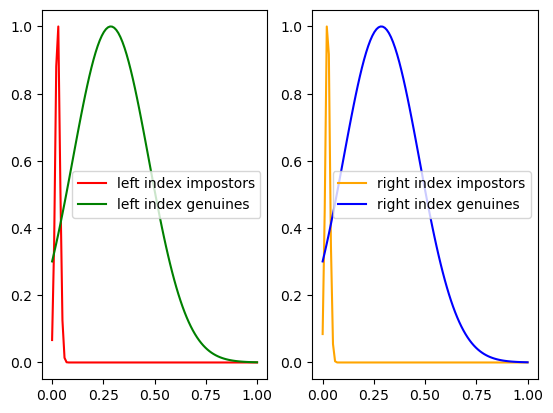

In [57]:
"""Plot the genuine and imposter score distributions."""

# Grab the genuine and impostor scores
li_genuines_scores = li_scores[li_genuine_id == 1]
li_impostors_scores = li_scores[li_genuine_id == 0]

ri_genuines_scores = ri_scores[ri_genuine_id == 1]
ri_impostors_scores = ri_scores[ri_genuine_id == 0]


# For simplicity, I fitted the impostor and genuine distributions to a Gausisian distribution. 
# Other distributions are of course possible.

# Impostor distribution parameters
li_mean_impostor = li_impostors_scores.mean()
li_variance_impostor = li_impostors_scores.var()
li_sigma_impostor = math.sqrt(li_variance_impostor)

ri_mean_impostor = ri_impostors_scores.mean()
ri_variance_impostor = ri_impostors_scores.var()
ri_sigma_impostor = math.sqrt(ri_variance_impostor) 

# x axis for plotting the gaussian distribution
#impostors = np.linspace(mean_impostor - 3*sigma_impostor, mean_impostor + 3*sigma_impostor, 100)
li_impostors = np.linspace(start=0, stop=1, num=100)
ri_impostors = np.linspace(start=0, stop=1, num=100)

# y axis: Normalize the probabilities for better visualization
li_prob_impostors = stats.norm.pdf(li_impostors, li_mean_impostor, li_sigma_impostor)
li_prob_impostors = li_prob_impostors / li_prob_impostors.max()
ri_prob_impostors = stats.norm.pdf(ri_impostors, ri_mean_impostor, ri_sigma_impostor)
ri_prob_impostors = ri_prob_impostors / ri_prob_impostors.max()
# preprocessing.normalize([stats.norm.pdf(impostors, mean_impostor, sigma_impostor)])[0]

plt.subplot(1,2,1)
plt.plot(li_impostors, li_prob_impostors, label='left index impostors', color='red')

plt.subplot(1,2,2)
plt.plot(ri_impostors, ri_prob_impostors, label='right index impostors', color='orange')

# Genuine distribution parameters
li_mean_genuine = li_genuines_scores.mean()
li_variance_genuine = li_genuines_scores.var()
li_sigma_genuine = math.sqrt(li_variance_genuine)

ri_mean_genuine = ri_genuines_scores.mean()
ri_variance_genuine = ri_genuines_scores.var()
ri_sigma_genuine = math.sqrt(ri_variance_genuine)

# x axis for plotting the gaussian distribution, should of course be the same to show both distributions on the same plot
li_genuines = np.linspace(0, 1, 100)
ri_genuines = np.linspace(0, 1, 100)

# y axis: Normalize the probabilities for better visualization
li_prob_genuines = stats.norm.pdf(ri_genuines, ri_mean_genuine, ri_sigma_genuine)
li_prob_genuines = li_prob_genuines / li_prob_genuines.max()

ri_prob_genuines = stats.norm.pdf(ri_genuines, ri_mean_genuine, ri_sigma_genuine)
ri_prob_genuines = ri_prob_genuines / ri_prob_genuines.max()

plt.subplot(1,2,1)
plt.plot(li_genuines, li_prob_genuines, label='left index genuines', color='green')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ri_genuines, ri_prob_genuines, label='right index genuines', color='blue')
plt.legend()

plt.show()

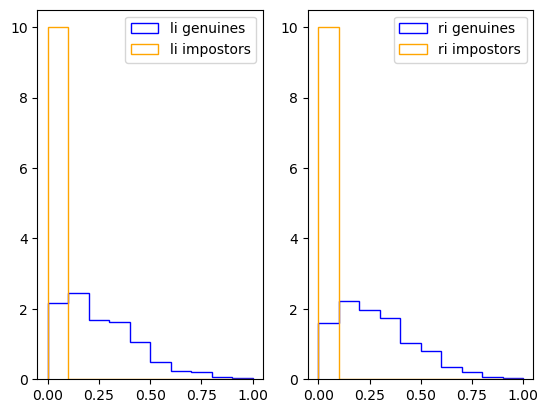

In [58]:
# I added a histogram distribution as well for an alternative

plt.subplot(1,2,1)
plt.hist(li_genuines_scores, label='li genuines', color='blue', range=(0,1), density=True, histtype='step')
plt.hist(li_impostors_scores, label='li impostors', color='orange', range=(0,1), density = True, histtype='step')
plt.legend()

plt.subplot(1,2,2)
plt.hist(ri_genuines_scores, label='ri genuines', color='blue', range=(0,1), density=True, histtype='step')
plt.hist(ri_impostors_scores, label='ri impostors', color='orange', range=(0,1), density = True, histtype='step')
plt.legend()

plt.show()

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of matching scores.</li>
    <li>Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

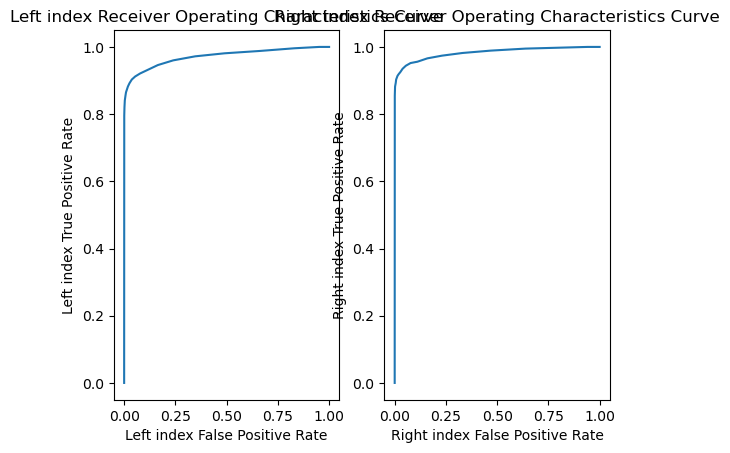

In [59]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

li_y_labels = li_genuine_id
li_y_scores = li_scores

ri_y_labels = ri_genuine_id
ri_y_scores = ri_scores

li_fpr, li_tpr, li_thresholds = roc_curve(li_y_labels, li_y_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_y_labels, ri_y_scores)

#print(fpr)
#print(tpr)
#print(li_thresholds)
#print(ri_thresholds)

plt.subplot(1,2,1)
plt.plot(li_fpr, li_tpr)
plt.xlabel('Left index False Positive Rate')
plt.ylabel('Left index True Positive Rate')
plt.title('Left index Receiver Operating Characteristics Curve')

plt.subplot(1,2,2)
plt.plot(ri_fpr, ri_tpr)
plt.xlabel('Right index False Positive Rate')
plt.ylabel('Right index True Positive Rate')
plt.title('Right index Receiver Operating Characteristics Curve')
plt.show()

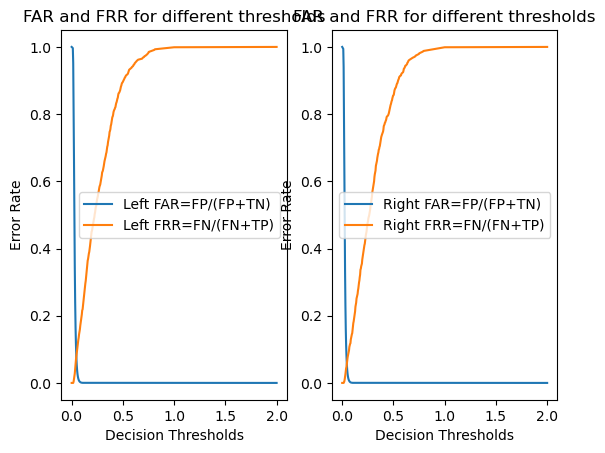

In [60]:
"""Plot FAR and FRR as a function of the decision threshold."""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR

li_frr = 1-li_tpr
#print(li_frr)
ri_frr = 1-ri_tpr
#print(ri_frr)

plt.subplot(1,2,1)
plt.plot(li_thresholds, li_fpr, label='Left FAR=FP/(FP+TN)')
plt.plot(li_thresholds, li_frr, label='Left FRR=FN/(FN+TP)')
plt.xlabel("Decision Thresholds")
plt.ylabel("Error Rate")
plt.title('FAR and FRR for different thresholds')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ri_thresholds, ri_fpr, label='Right FAR=FP/(FP+TN)')
plt.plot(ri_thresholds, ri_frr, label='Right FRR=FN/(FN+TP)')
plt.xlabel("Decision Thresholds")
plt.ylabel("Error Rate")
plt.title('FAR and FRR for different thresholds')
plt.legend()

plt.show()


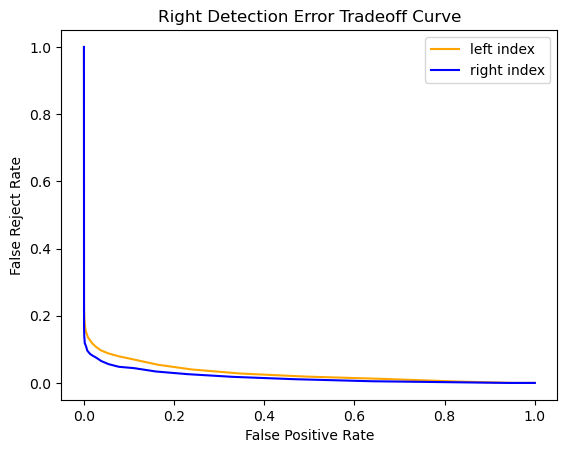

In [61]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""

# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR

#plt.subplot(1,2,1)
plt.plot(li_fpr, li_frr, label='left index', color='orange')
plt.xlabel("False Positive Rate")
plt.ylabel("False Reject Rate")
plt.title('Left Detection Error Tradeoff Curve')

#plt.subplot(1,2,2)
plt.plot(ri_fpr, ri_frr, label='right index', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("False Reject Rate")
plt.title('Right Detection Error Tradeoff Curve')

plt.legend()
plt.show()

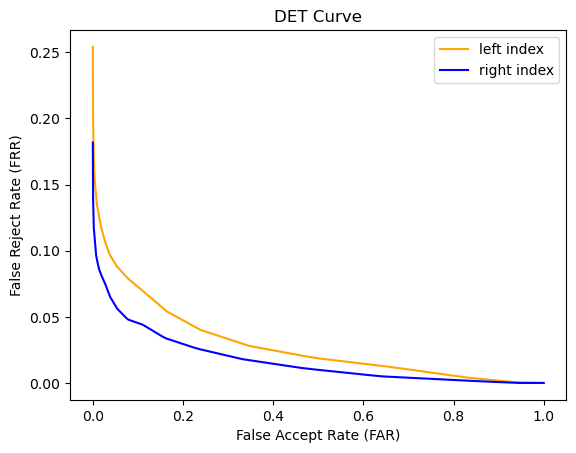

In [62]:
from scipy.interpolate import interp1d

# An alternate visualization using the logs of fpr and frr.

# Interpolate (map) function to map the values of fpr to the values of frr linearly
li_f = interp1d(li_fpr, li_frr, kind='linear')
ri_f = interp1d(ri_fpr, ri_frr, kind='linear')

# Compute the logarithms of far and fpr to get a better visualization
li_log_fpr = np.logspace(-4, 0, li_fpr.size)
li_log_frr = li_f(li_log_fpr)
ri_log_fpr = np.logspace(-4, 0, ri_fpr.size)
ri_log_frr = ri_f(ri_log_fpr)
#print(log_fpr)
#print(log_frr)

# Plot the DET curve
plt.plot(li_log_fpr, li_log_frr, label='left index', color='orange')
plt.plot(ri_log_fpr, ri_log_frr, label='right index', color='blue')

plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.title('DET Curve')

plt.legend()
plt.show()


#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Do the same for the classification error (accuracy). Is there a difference?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


[0.700454840805718, 0.707175177763413, 0.7096774193548387, 0.7187700192184499, 0.734977862112587, 0.743718592964824, 0.7503121098626717, 0.7572936064556176, 0.7611386138613861, 0.7732843137254902, 0.7770311545510079, 0.7859308671922377, 0.793993993993994, 0.7988059701492538, 0.8087625814091179, 0.8140350877192982, 0.8152866242038217, 0.8208027133973996, 0.8143646408839779, 0.8089033659066232, 0.7987388334209143, 0.7829614604462476, 0.7589893100097181, 0.7222478120681713, 0.6815068493150684, 0.6196531791907514, 0.5468013468013467, 0.47774221704975267, 0.40183974824497704, 0.328901055924912, 0.2625793466480879, 0.20506055882000238, 0.1582075903063557, 0.11876064010895473, 0.08771755345599205, 0.06387854482956172, 0.04599398971120053, 0.03279631760644419, 0.02308907217528642, 0.016218523260776784, 0.011386752368227832, 0.007962575893301484, 0.005581924213319091, 0.0039933403620465765, 0.002977482038671103, 0.002393554705101324, 0.0020984156961494074, 0.002005038662158003, 0.00199800199800

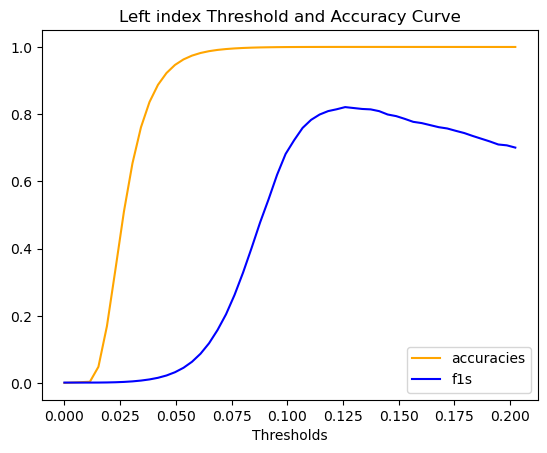

In [63]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice

li_f1s = []
li_accuracies = []

li_thresholds_subset = li_thresholds[100:150] # The thresholds ranging between 0.2 and 0

li_threshold_f1_max = 0
li_threshold_acc_max = 0
li_f1_max = 0
li_acc_max = 0

for threshold in li_thresholds_subset:
    li_predictions = (li_y_scores >= threshold).astype(int)
    f1 = f1_score(li_y_labels, li_predictions)
    li_f1s.append(f1)
    accuracy = accuracy_score(li_y_labels, li_predictions)
    li_accuracies.append(accuracy)
    if(li_f1_max < f1):
        li_f1_max = f1
        li_threshold_f1_max = threshold
    if(li_acc_max < accuracy):
        li_acc_max = accuracy
        li_threshold_acc_max = threshold
    
print(li_f1s)
print(li_accuracies)

plt.plot(li_thresholds_subset, li_accuracies, label='accuracies', color='orange')
plt.plot(li_thresholds_subset, li_f1s, label='f1s', color='blue')

plt.xlabel('Thresholds')
plt.title('Left index Threshold and Accuracy Curve')

plt.legend()
plt.show()

50
[0.25174825 0.24825175 0.24475524 0.24125874 0.23776224 0.23426573
 0.23076923 0.22727273 0.22377622 0.22027972 0.21678322 0.21328671
 0.20979021 0.20629371 0.2027972  0.1958042  0.19230769 0.18531469
 0.18181818 0.17832168 0.17482517 0.17132867 0.16783217 0.16433566
 0.15734266 0.15384615 0.15034965 0.14685315 0.14335664 0.13986014
 0.13636364 0.13286713 0.12937063 0.12587413 0.12237762 0.11888112
 0.11538462 0.11188811 0.10839161 0.1048951  0.1013986  0.0979021
 0.09440559 0.09090909 0.08741259 0.08391608 0.08041958 0.07692308
 0.07342657 0.06993007]
[0.6833443054641211, 0.6868023637557452, 0.6928104575163399, 0.6996098829648895, 0.7088444157520982, 0.7129987129987131, 0.717948717948718, 0.7253027405991077, 0.7317691819911224, 0.7389659520807063, 0.7421383647798743, 0.7476518472135253, 0.7538940809968847, 0.7585350713842334, 0.7646695491043854, 0.775260257195346, 0.78419452887538, 0.7900786448880823, 0.7951807228915663, 0.7973541791942274, 0.8081048867699643, 0.8130563798219584, 0

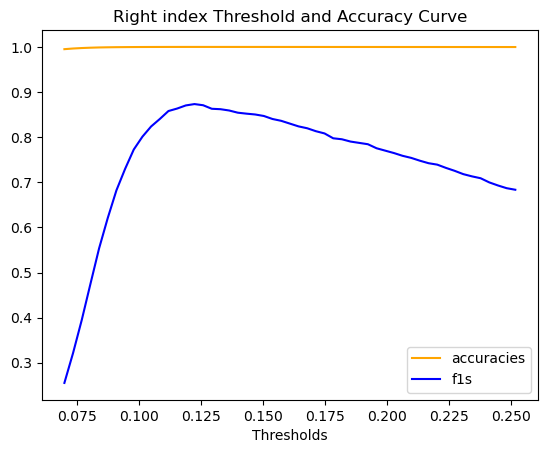

In [64]:
"""Same for right index"""
# Hint: evaluating for ± 50 threshold values should suffice

ri_f1s = []
ri_accuracies = []

ri_thresholds_subset = ri_thresholds[100:150] # The thresholds ranging between 0.25 and 0
print(ri_thresholds_subset.size)
print(ri_thresholds_subset)

ri_threshold_f1_max = 0
ri_threshold_acc_max = 0
ri_f1_max = 0
ri_acc_max = 0

for threshold in ri_thresholds_subset:
    ri_predictions = (ri_y_scores >= threshold).astype(int)
    f1 = f1_score(ri_y_labels, ri_predictions)
    ri_f1s.append(f1)
    accuracy = accuracy_score(ri_y_labels, ri_predictions)
    ri_accuracies.append(accuracy)
    if(ri_f1_max < f1):
        ri_f1_max = f1
        ri_threshold_f1_max = threshold
    if(ri_acc_max < accuracy):
        ri_acc_max = accuracy
        ri_threshold_acc_max = threshold
    
print(ri_f1s)
print(ri_accuracies)

plt.plot(ri_thresholds_subset, ri_accuracies, label='accuracies', color='orange')
plt.plot(ri_thresholds_subset, ri_f1s, label='f1s', color='blue')

plt.xlabel('Thresholds')
plt.title('Right index Threshold and Accuracy Curve')

plt.legend()
plt.show()

In [65]:
"""Calculate the threshold for which F1 is maximal."""

print("Left index F1 Max: " + str(li_f1_max))
print("Left index Threshold F1 Max: " + str(li_threshold_f1_max))
print("Left index Acc Max: " + str(li_acc_max))
print("Left index Threshold Acc Max: " + str(li_threshold_acc_max))

print("Right index F1 Max: " + str(ri_f1_max))
print("Right index Threshold F1 Max: " + str(ri_threshold_f1_max))
print("Right index Acc Max: " + str(ri_acc_max))
print("Right index Threshold Acc Max: " + str(ri_threshold_acc_max))

Left index F1 Max: 0.8208027133973996
Left index Threshold F1 Max: 0.12595419847328243
Left index Acc Max: 0.999683
Left index Threshold Acc Max: 0.12595419847328243
Right index F1 Max: 0.8731466227347611
Right index Threshold F1 Max: 0.12237762237762238
Right index Acc Max: 0.999769
Right index Threshold Acc Max: 0.12237762237762238


In [66]:
"""Do the same for the classification error (or accuracy)"""

"""
It's the same threshold for both of them.

The accuracy can be a misleading metric in our example since there is a high class imbalance and 
labeling most classes as negative until a certain threshold, provides a significantly high accuracy rate (%99).

Therefore, it makes more sense to use other metrics such as the f1 score.
Below are the formulas for f1 score and accuracy score, which highlights their difference:

precision = true positives / (true positives + false positives)
recall = true positives / (true positives + false negatives)

f1_score = 2 * (precision * recall) / (precision + recall)
accuracy =  true classifications (tp + tn) / whole dataset

As we can see, with accuracy score, we can in a way get away by being very strict and rejecting a majority 
of the dataset and still get a high accuracy. To be more precise, we should reject the majority of the dataset 
in our case, but the accuracy score fails to properly show our performance.

Therefore, the f1 score provides a much better metric to measure the performance since:

1- It focuses only on the positive classes and not the whole dataset (since the whole dataset is imbalanced)
2- It considers both false negatives and false positives. Recall prevents us from being too strict and 
precision prevents us from giving too much leeway.

"""

"\nIt's the same threshold for both of them.\n\nThe accuracy can be a misleading metric in our example since there is a high class imbalance and \nlabeling most classes as negative until a certain threshold, provides a significantly high accuracy rate (%99).\n\nTherefore, it makes more sense to use other metrics such as the f1 score.\nBelow are the formulas for f1 score and accuracy score, which highlights their difference:\n\nprecision = true positives / (true positives + false positives)\nrecall = true positives / (true positives + false negatives)\n\nf1_score = 2 * (precision * recall) / (precision + recall)\naccuracy =  true classifications (tp + tn) / whole dataset\n\nAs we can see, with accuracy score, we can in a way get away by being very strict and rejecting a majority \nof the dataset and still get a high accuracy. To be more precise, we should reject the majority of the dataset \nin our case, but the accuracy score fails to properly show our performance.\n\nTherefore, the f1

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.</li>
</ul>  
</div>


In [67]:
"""Calculate the ROC AUC."""

print("Left index ROC Area Under the Curve Score: " + str(roc_auc_score(li_y_labels, li_y_scores)))
print("Right index ROC Area Under the Curve Score: " + str(roc_auc_score(ri_y_labels, ri_y_scores)))

"""
A higher AUC score indicates that the curve leans more towards the top left, meaning that
the classifer operates better. A score of 0.5 means that the classifier cannot distinguish the two classes 
and the prediction is basically the same as a coin toss
"""

Left index ROC Area Under the Curve Score: 0.9712470650650651
Right index ROC Area Under the Curve Score: 0.9826611286286288


'\nA higher AUC score indicates that the curve leans more towards the top left, meaning that\nthe classifer operates better. A score of 0.5 means that the classifier cannot distinguish the two classes \nand the prediction is basically the same as a coin toss\n'

Left index FPR point at EER : 0.07793493493493493
Left index FRR point at EER : 0.07899999999999996
Right index FPR point at EER : 0.054403403403403404
Right index FRR point at EER : 0.05600000000000005
Left index EER is: 0.07846746746746744
Right index EER is: 0.05520170170170173


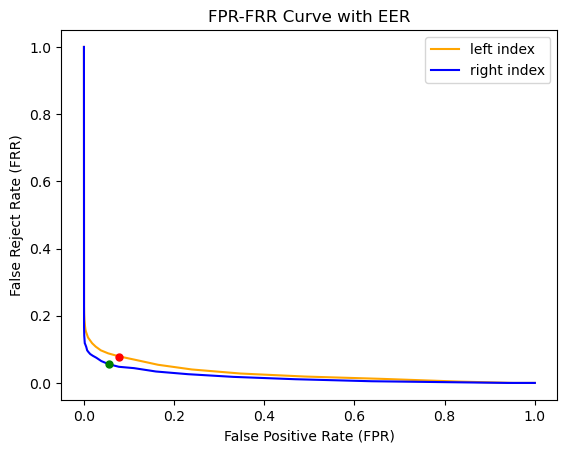

In [68]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment 

li_min_distance = float('inf')
li_min_accuracy = 0
li_eer_threshold = 0
li_eer_index = 0
li_distances = np.array([])

for i, threshold in enumerate(li_thresholds):
    distance = abs(li_fpr[i] - li_frr[i])
    accuracy = accuracy_score(li_y_labels, li_predictions)
    li_distances = np.append(li_distances, distance)
    if distance < li_min_distance:
        li_min_distance = distance
        li_eer_threshold = threshold
        li_eer_index = i
        li_min_accuracy = accuracy
        
print("Left index FPR point at EER : " + str(li_fpr[li_eer_index]))
print("Left index FRR point at EER : " + str(li_frr[li_eer_index]))

ri_min_distance = float('inf')
ri_min_accuracy = 0
ri_eer_threshold = 0
ri_eer_index = 0
ri_distances = np.array([])

for i, threshold in enumerate(ri_thresholds):
    distance = abs(ri_fpr[i] - ri_frr[i])
    accuracy = accuracy_score(ri_y_labels, ri_predictions)
    ri_distances = np.append(ri_distances, distance)
    if distance < ri_min_distance:
        ri_min_distance = distance
        ri_eer_threshold = threshold
        ri_eer_index = i
        ri_min_accuracy = accuracy
        
print("Right index FPR point at EER : " + str(ri_fpr[ri_eer_index]))
print("Right index FRR point at EER : " + str(ri_frr[ri_eer_index]))

li_eer = (li_fpr[li_eer_index] + li_frr[li_eer_index]) / 2
ri_eer = (ri_fpr[ri_eer_index] + ri_frr[ri_eer_index]) / 2

print("Left index EER is: " + str(li_eer))
print("Right index EER is: " + str(ri_eer))

# Plot the EER on the FPR-FRR curve
plt.plot(li_fpr, li_frr, label='left index', color='orange')
plt.plot(ri_fpr, ri_frr, label='right index', color='blue')
plt.plot(li_eer, li_eer, marker='o', markersize=5, color='red')
plt.plot(ri_eer, ri_eer, marker='o', markersize=5, color='green')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('False Reject Rate (FRR)')
#plt.ylabel('True Positive Rate (TPR)')
plt.title('FPR-FRR Curve with EER')
plt.legend()
plt.show()


Li EER Threshold:0.04580152671755725
Ri EER Threshold:0.045454545454545456
Li Acc Threshold:0.12595419847328243
Ri Acc Threshold:0.12237762237762238


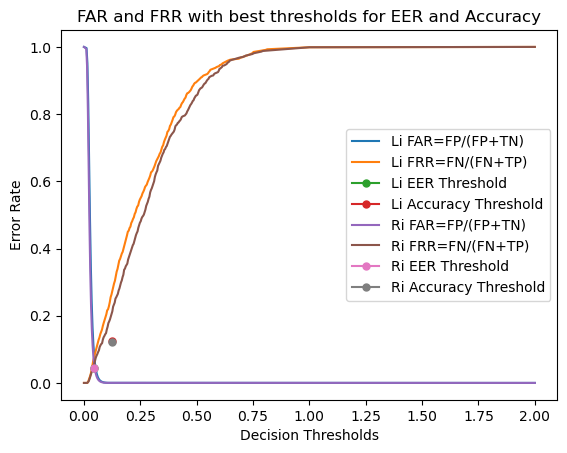

In [69]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above

print("Li EER Threshold:" + str(li_eer_threshold))
print("Ri EER Threshold:" + str(ri_eer_threshold))
print("Li Acc Threshold:" + str(li_threshold_acc_max))
print("Ri Acc Threshold:" + str(ri_threshold_acc_max))

plt.plot(li_thresholds, li_fpr, label='Li FAR=FP/(FP+TN)')
plt.plot(li_thresholds, li_frr, label='Li FRR=FN/(FN+TP)')
plt.plot(li_eer_threshold, li_eer_threshold, marker='o', markersize=5, label="Li EER Threshold")
plt.plot(li_threshold_acc_max, li_threshold_acc_max, marker='o', markersize=5, label="Li Accuracy Threshold")

plt.plot(ri_thresholds, ri_fpr, label='Ri FAR=FP/(FP+TN)')
plt.plot(ri_thresholds, ri_frr, label='Ri FRR=FN/(FN+TP)')
plt.plot(ri_eer_threshold, ri_eer_threshold, marker='o', markersize=5, label="Ri EER Threshold")
plt.plot(ri_threshold_acc_max, ri_threshold_acc_max, marker='o', markersize=5, label="Ri Accuracy Threshold")

plt.xlabel("Decision Thresholds")
plt.ylabel("Error Rate")
plt.title('FAR and FRR with best thresholds for EER and Accuracy')

plt.legend()
plt.show()

#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">
<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for this system. What does it reveal about the performance of the system?</li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


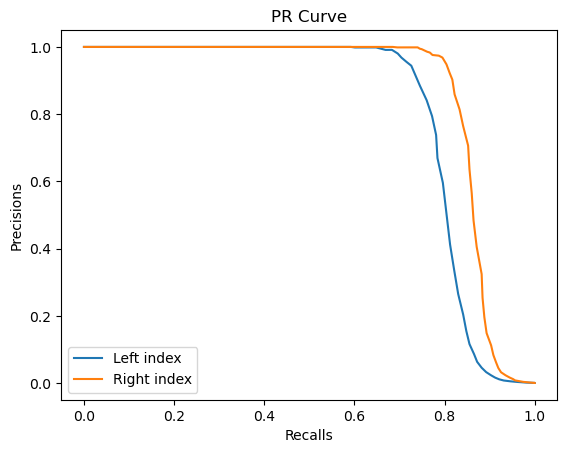

In [70]:
"""Calculate and plot the Precision-Recall curve for this system"""

from sklearn.metrics import precision_recall_curve, auc, average_precision_score

li_precisions, li_recalls, li_thresholds = precision_recall_curve(li_y_labels, li_y_scores)
ri_precisions, ri_recalls, ri_thresholds = precision_recall_curve(ri_y_labels, ri_y_scores)

#print(thresholds)
#print(precisions)
#print(recalls)

plt.plot(li_recalls, li_precisions, label='Left index')
plt.plot(ri_recalls, ri_precisions, label='Right index')

plt.xlabel("Recalls")
plt.ylabel("Precisions")
plt.title("PR Curve")
plt.legend()
plt.show()

In [47]:
"""
The Precision-Recall curve reveals how well the system performs at different classification thresholds. 
In general, a good system should have high Precision and high Recall, 
which means that it correctly identifies most of the positive instances and avoids falsely 
classifying negative instances as positive. However, there is often a trade-off between Precision and Recall,
as increasing one metric may come at the cost of decreasing the other. 
The Precision-Recall curve can help us visualize this trade-off and 
choose the optimal classification threshold for our particular use case.
"""

'\nThe Precision-Recall curve reveals how well the system performs at different classification thresholds. \nIn general, a good system should have high Precision and high Recall, \nwhich means that it correctly identifies most of the positive instances and avoids falsely \nclassifying negative instances as positive. However, there is often a trade-off between Precision and Recall,\nas increasing one metric may come at the cost of decreasing the other. \nThe Precision-Recall curve can help us visualize this trade-off and \nchoose the optimal classification threshold for our particular use case.\n'

In [71]:
"""Calculate the Area Under the PR-curve."""
li_auc_pr = auc(li_recalls, li_precisions)
print(li_auc_pr)
ri_auc_pr = auc(ri_recalls, ri_precisions)
print(ri_auc_pr)

0.8034780801507486
0.8627573994779723


In [72]:
"""Calculate the average precision scores"""
print(average_precision_score(li_y_labels, li_y_scores))
print(average_precision_score(ri_y_labels, ri_y_scores))


0.7988972537365138
0.8595122882879993


## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


[0.858 0.917 0.938 0.957 0.963 0.97  0.975 0.981 0.985 0.986 0.988 0.988
 0.989 0.99  0.992 0.995 0.997 0.998 0.998 0.998 0.999 0.999 0.999 0.999
 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.   ]
[0.9   0.936 0.955 0.963 0.971 0.977 0.981 0.984 0.988 0.988 0.991 0.992
 0.994 0.994 0.994 0.994 0.995 0.995 0.995 0.996 0.996 0.996 0.997 0.997
 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997 0.997
 0.997 0.997 0.997 0.997 0.998 0.998 0.998 0.998 0.998 0.998 0.998 0.998
 0.998 0.998]


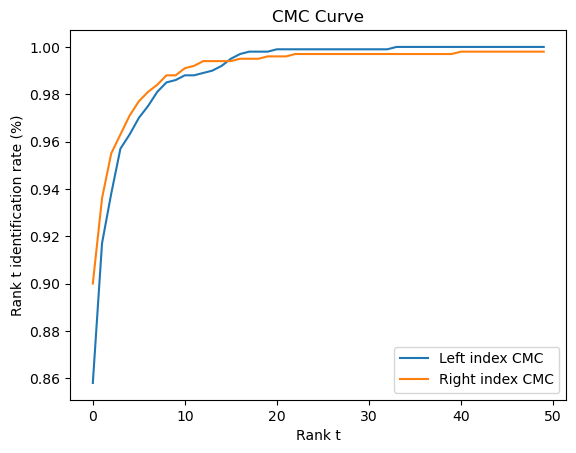

In [78]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library

def calculate_cmc(similarity_matrix, true_ids, max_rank):
    # Sort the similarity matrix in descending order based on the matched/predicted ids
    sorted_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1]
    sorted_ids = true_ids[sorted_indices]
    
    # Calculate the cumulative match curve for each rank
    cmc = np.zeros(max_rank)
    for i in range(len(true_ids)):
        # Get the first max_rank number of columns in the sorted matrix.
        # If the id is identified in the first n (max_rank) number of guesses, it is marked as 1 (a match)
        matches = (sorted_ids[:, :max_rank] == true_ids[i])
        
        # We sum all of the matches, first in the n number of guesses (which will be 1 or 0 in total),
        # and then for all the ids/indexes, which will give us our correct guesses/matches in total.
        matches_cumsum = np.cumsum(matches, axis=1)
        cmc += np.any(matches_cumsum, axis=0)
        
    cmc /= len(sorted_ids)
    print(cmc)

    return cmc

max_rank = 50
li_cmc_array = calculate_cmc(np.array(li_similarity_matrix), np.array(li_similarity_matrix.index), max_rank)
ri_cmc_array = calculate_cmc(np.array(ri_similarity_matrix), np.array(ri_similarity_matrix.index), max_rank)

x_axis = np.arange(0, max_rank)
plt.plot(x_axis, li_cmc_array, label='Left index CMC')
plt.plot(x_axis, ri_cmc_array, label='Right index CMC')

plt.xlabel("Rank t")
plt.ylabel("Rank t identification rate (%)")
plt.title("CMC Curve")

plt.legend()
plt.show()

In [79]:
"""compute the Rank-1 Recognition Rate."""

li_rank1_acc = li_cmc_array[0]
print(li_rank1_acc)
ri_rank1_acc = ri_cmc_array[0]
print(ri_rank1_acc)

0.858
0.9


<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Use above evaluation techniques to compare the biometric system based on the left index to the right index </li>
    <li>Do you see any differences in any of the curves or measures?</li>
</ul>  
</div>

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 3-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Feel free to add figures and, if needed, some *small* code snippet to clarify your position. **The report should be self contained, the notebook functions as supplementary material only!**

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
